In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
run -im djd.main -- --dbname=dj_hmov --r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting execute@localhost:3306
Connected to database 'dj_hmov' as 'execute@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSHFS with `hux -r`


In [4]:
from djd import hmov_unit
from djd import hmov_models

In [5]:
from sklearn.decomposition import randomized_svd

# Unit wiht center surround RF

In [6]:
key = {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 6, 'u':6, 'spl_paramset': 8}

	Eye() is empty for key  {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 6, 'u': 6, 'spl_paramset': 8}
	Data object loaded without eye attributes.


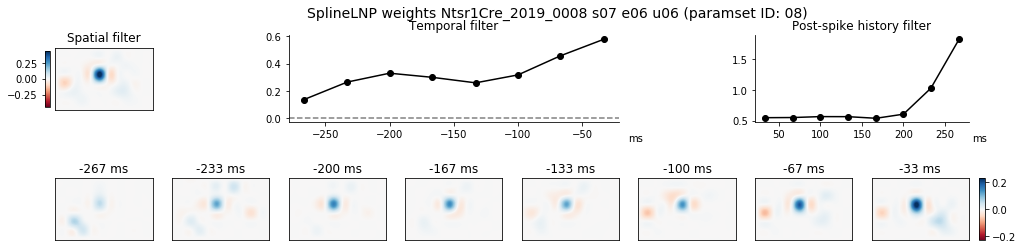

In [7]:
fig, ax = hmov_models.plot_RF(key, train_test_psth=False)

In [8]:
strf = (SplineLNP() & key).fetch1('spl_w_opt') # fetch spatio-temporal receptive field

### Perform SVD to get spatial component (sRF)

In [9]:
# norm RF
strf_vec = strf.flatten()
k_norm = strf_vec / np.linalg.norm(strf_vec)

# SVD
dims_tRF = strf.shape[0]
dims_sRF = strf.shape[1:]
U, S, Vt = randomized_svd(k_norm.reshape(dims_tRF, np.prod(dims_sRF)), 3)
sRF = Vt[0].reshape(*dims_sRF)

Text(0.5, 1.0, 'Spatial RF')

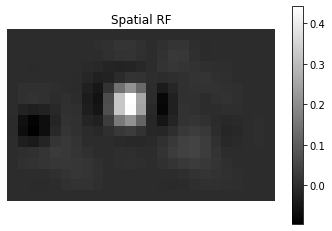

In [10]:
# plot sRF
plt.imshow(sRF, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.title('Spatial RF')

### Find contour lines for center RF

In [11]:
rf_qi, level_center = hmov_models.get_rf_qi(strf)

Good looking RF -> we'd expect a quality index close to 1.0

In [12]:
rf_qi

0.8867974625806129

Plot contour line that masks the surround:

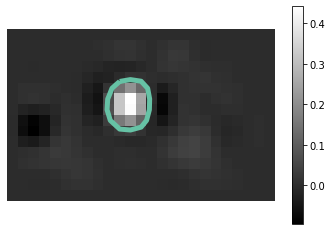

In [13]:
# plot sRF
plt.imshow(sRF, cmap='gray')
plt.colorbar()
plt.axis('off')

# contour lines
contourlines = plt.contour(sRF, levels=[level_center], cmap='Set2', linewidths=5.0)
contours_l = contourlines.collections[0].get_paths()

### Analyze the surround

Mask the center:

In [14]:
nx, ny = (25, 16)
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
xv, yv = np.meshgrid(x, y)
points = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))
mask = contours_l[0].contains_points(points)
mask.shape = xv.shape

(-0.5, 24.5, 15.5, -0.5)

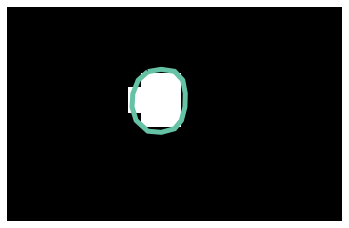

In [16]:
plt.imshow(mask, cmap='gray')
plt.contour(sRF, levels=[level_center], cmap='Set2', linewidths=5.0)
plt.axis('off')

Set center to zero to analyze the surround:

In [17]:
sRF_wo_center = sRF.copy()
sRF_wo_center[mask] = 0

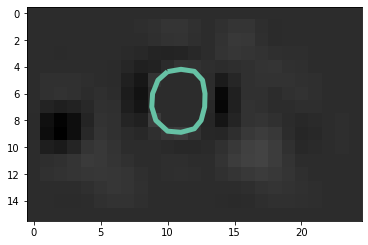

In [19]:
plt.imshow(sRF_wo_center, vmin=np.min(sRF), vmax=np.max(sRF), cmap='gray')
plt.contour(sRF, levels=[level_center], cmap='Set2', linewidths=5.0)
#plt.colorbar()

Mask the surround by using the `radius` to enlarge the area around RF center:

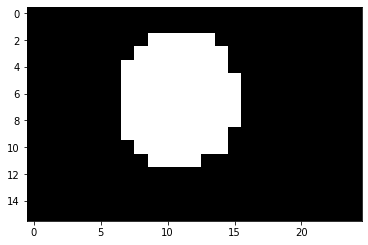

In [20]:
mask_surround = contours_l[0].contains_points(points, radius=5.)
mask_surround.shape = xv.shape
plt.imshow(mask_surround, cmap='gray')

## TODO: How to get the radius that should be considered here automatically for all cells?
Here it was set to 5.0 by trying out...

Get pixels in the surround:

In [21]:
pixels_surround = sRF_wo_center[mask_surround]

Now, you can use things such as the mininmun (if off surround) or the sum over all surround pixels:

In [22]:
min(pixels_surround)

-0.08183672867840766

In [23]:
np.sum(pixels_surround)

-0.6676999546637069

Idea: calculate the ratio between center peak and surround peak (or sum) to get the strength of the center surround characteristic?